# Práctica 1
---

In [82]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import sys
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle
import gzip
import os

from sklearn.linear_model import LinearRegression

import networkx as nx

In [84]:
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50, decimals=0):
    graph = [[np.inf for i in range(0,n_nodes)] for j in range(0,n_nodes)]
    for i in range(0,n_nodes):
        for j in range(0,n_nodes):
            if i!=j and random.random()<=sparse_factor:
                graph[i][j] = random.randint(1,max_weight)
    return graph


def cuenta_ramas(m_g):
    l=0
    for i in range(0, len(m_g)):
        for j in range(0, len(m_g)):
            if m_g[i][j]<float('inf'):
                l += 1
    return l


def calculate_sparse_factor(g):
    return (cuenta_ramas(g))/(len(g)*(len(g)-1.0))


def check_sparse_factor(n_grafos, n_nodes, sparse_factor):
    values = [calculate_sparse_factor(rand_matr_pos_graph(n_nodes,sparse_factor)) for i in range(0, n_grafos)]
    return sum(values)/(n_grafos)

In [85]:
check_sparse_factor(20, 20, 0.85)

0.8461842105263158

In [86]:
def m_g_2_d_g(m_g):
    graph = {}
    for i in range(0,len(m_g)):
        graph[i] = {}
        for j in range(0, len(m_g)):
            if m_g[i][j] < np.inf:
                graph[i][j] = m_g[i][j]
    return graph


def d_g_2_m_g(d_g):
    graph = [[np.inf for i in range(0,len(d_g))] for j in range(0,len(d_g))]
    for v1 in d_g:
        for v2 in d_g[v1]:
            graph[v1][v2] = d_g[v1][v2]
    return graph

In [87]:
def save_object(obj, f_name='obj.pklz', save_path='.'):
    complete_name = os.path.join(save_path, f_name)
    with gzip.open(complete_name) as f:
        f.write(pickle.dump(obj))
        
        
def read_object(f_name, save_path='.'):
    complete_name = os.path.join(save_path, f_name)
    obj = None
    with gzip.open(complete_name) as f:
        obj = pickle.load(f.read())
    return obj

In [88]:
# Trivial Graph Format (TGF)
def d_g_2_TGF(d_g, f_name):
    out = ''
    for v1 in d_g:
        out += str(v1)+'\n'
    out += '#\n'
    for v1 in d_g:
        for v2 in d_g[v1]:
            out += str(v1)+' '+str(v2)+' '+str(d_g[v1][v2])+'\n'
    with open(f_name,'w') as f:
        f.write(out)        
        

def TGF_2_d_g(f_name):
    with open(f_name) as f:
        tgf = f.read()
    nodes, edges = tgf.split('#\n')
    nodes = nodes.split('\n')[:-1] # Last is empty
    edges = list(map(lambda x: x.split(' '), edges.split('\n')[:-1]))
    graph = {}
    for node in nodes:
        graph[int(node)] = {}
    for v1, v2, weight in edges:
        graph[int(v1)][int(v2)] = float(weight)
    return graph

In [146]:
# DIJKSTRA!
from queue import PriorityQueue

def dijkstra_d(d_g, u):
    dist = {}
    prev = {}
    visited = {}
    for ele in d_g:
        dist[ele] = np.inf
        prev[ele] = -1
        visited[ele] = False
    q = PriorityQueue()
    dist[u] = 0
    q.put((0, u))
    while not q.empty():
        w, curr = q.get()
        if not visited[curr]:
            visited[curr] = True
            for node in d_g[curr]:
                if d_g[curr][node]+w < dist[node]:
                    dist[node] = d_g[curr][node]+w
                    prev[node] = curr
                    q.put((dist[node], node))
    return dist, prev
    
    
def dijkstra_m(m_g, u):
    dist = {}
    prev = {}
    visited = {}
    for ele in range(len(m_g)):
        dist[ele] = np.inf
        prev[ele] = -1
        visited[ele] = False
    q = PriorityQueue()
    dist[u] = 0
    q.put((0, u))
    while not q.empty():
        w, curr = q.get()
        if not visited[curr]:
            visited[curr] = True
            for node in range(len(m_g[curr])):
                if m_g[curr][node]+w < dist[node]:
                    dist[node] = m_g[curr][node]+w
                    prev[node] = curr
                    q.put((dist[node], node))
    return dist, prev


def min_path(d_prev, v):
    if d_prev[v]<0:
        return [] # There is no path
    path = [v]
    while d_prev[v]>=0:
        v = d_prev[v]
        path.append(v)
    path.reverse()
    return path    
    
def min_paths(d_prev):
    d_path = {}
    for ele in d_prev:
        d_path[ele] = min_path(d_prev, ele)
    return d_path

In [187]:
from time import time


def time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, generate, dijks, sparse_factor=.25):
    times = [] # Returning list
    for nodes in range(n_nodes_ini, n_nodes_fin+1, step):
        meanTime = 0
        for _ in range(n_graphs):
            graph = generate(nodes, sparse_factor) 
            time_ini = time()
            for i in range(nodes):
                dijks(graph,i)
            meanTime += (time()-time_ini)
        times.append(meanTime/(n_graphs*nodes))
    return times
    
    
def time_dijkstra_m(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    return time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, rand_matr_pos_graph, dijkstra_m, sparse_factor=sparse_factor)
    
    
def time_dijkstra_d(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    f = lambda x,y: m_g_2_d_g(rand_matr_pos_graph(x,y))
    return time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, f, dijkstra_d, sparse_factor=sparse_factor)


In [188]:
print(time_dijkstra_m(10,10, 100, 10))
print(time_dijkstra_d(10,10, 100, 10))

[0.0001383042335510254, 0.00017061233520507813, 0.00031570990880330405, 0.0004917144775390625, 0.0007189354896545411, 0.0009432927767435709, 0.0011840527398245676, 0.0015858092904090881, 0.001842192014058431, 0.002145193099975586]
[4.799842834472656e-05, 0.000140305757522583, 0.000247338612874349, 0.0004408943653106689, 0.0005528616905212402, 0.0006647213300069174, 0.0008937481471470424, 0.0010431453585624695, 0.0013152792718675401, 0.0013840587139129638]


In [189]:
def fit_plot(l, func_2_fit, size_ini, size_fin, step, label=None):
    l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    if label:
        plt.plot(l, '*', y_pred, '-', label=label)
        return
    plt.plot(l, '*', y_pred, '-')
    
def n2_log_n(n):
    return n**2. * np.log(n)

In [190]:
args = [20,10,100,10]

In [191]:
x = [x for x in range(args[1],args[2]+1,args[3])]
y = time_dijkstra_m(*args,sparse_factor=0.7)
y2 = time_dijkstra_d(*args,sparse_factor=0.7)

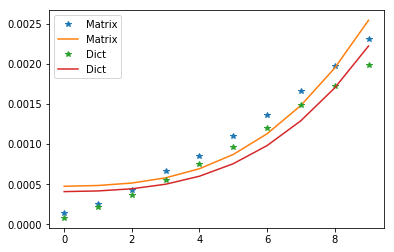

In [199]:
# Plot fitted
fit_plot(y, n2_log_n, *args[1:],label='Matrix')
fit_plot(y2, n2_log_n, *args[1:],label='Dict')
plt.legend(loc='upper left')


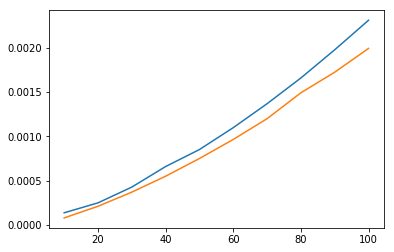

In [193]:
plt.plot(x,y)
plt.plot(x,y2)
plt.legend(loc='upper left')


# REVISAR LAS FUNCIONES DE DIJKSTRA PORQUE PARECEN LINEALES Y ESTO ES SOSPECHOSO. Lo puedes comprobar con el dijkstra de nx

In [194]:
def edges(d_g):
    e = []
    for u in d_g:
        for v in d_g[u]:
            e.append((u,v,d_g[u][v]))
    return e


def d_g_2_nx_g(d_g):
    g = nx.DiGraph()
    g.add_weighted_edges_from(edges(d_g))
    return g

def nx_g_2_d_g(nx_g):
    d_g = {}
    for u in nx_g:
        d_g[u] = {}
        for v in nx_g[u]:
            d_g[u][v] = nx_g[u][v]['weight']

In [195]:
def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):    
    f = lambda x,y: d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(x,y)))
    return time_dijkstra(n_graphs, n_nodes_ini, n_nodes_fin, step, f, nx.single_source_dijkstra, sparse_factor=sparse_factor)


In [196]:
ynx = time_dijkstra_nx(*args)

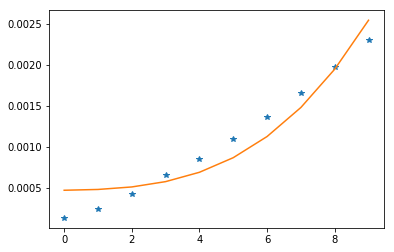

In [197]:
fit_plot(y, n2_log_n, *args[1:],label='Nx')
